**Notebook Airline Ticker Dynamic Pricing**

---
# Import Pustaka yang Dibutuhkan

In [7]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import streamlit as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


pd.set_option("display.max_columns", None) #untuk menampilkan semua kolom dataframe
pd.set_option("display.max_rows", None) #untuk menampilkan semua baris dataframe

In [8]:
# Mengatur tampilan dan mengabaikan peringatan
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
pd.set_option("display.max_columns", None)

In [9]:
# Import file
df_raw = pd.read_csv("Flight_Price.csv")

---
# 1. Business Understanding
Link data : https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

**Latar Belakang:**  

Harga tiket pesawat sangat fluktuatif karena dipengaruhi berbagai faktor seperti waktu pembelian, rute perjalanan, kelas penerbangan, maskapai, dan waktu keberangkatan. Hal ini menyebabkan:

- Pelanggan kesulitan mengetahui waktu terbaik membeli tiket.

- Maskapai penerbangan dan agen perjalanan (OTA) kesulitan menentukan harga optimal yang kompetitif sekaligus menguntungkan.

**Tujuan proyek:**  

Membangun model machine learning yang mampu memprediksi harga tiket pesawat dengan akurat berdasarkan fitur-fitur berikut:
- Maskapai (airline)
- Kota asal dan tujuan (source_city, destination_city)
- Waktu keberangkatan dan kedatangan (departure_time, arrival_time)
- Jumlah transit (stops)
- Kelas penerbangan (class)
- Lama penerbangan (duration)
- Waktu pembelian sebelum keberangkatan (days_left)

**Tujuan Utama:**  

Membuat model dynamic pricing (penetapan harga dinamis). Artinya, perusahaan penerbangan ingin menetapkan harga tiket secara fleksibel berdasarkan berbagai faktor untuk memaksimalkan pendapatan dan tingkat keterisian kursi (okupansi).

**Pertanyaan Kunci Bisnis:**

- Faktor apa saja yang paling signifikan mempengaruhi harga tiket pesawat? (misalnya: maskapai, rute, waktu pemesanan, kelas penerbangan).

- Bagaimana harga berubah seiring mendekati tanggal keberangkatan?

- Bisakah kita memprediksi harga tiket secara akurat untuk kombinasi rute, maskapai, dan waktu tertentu?

**Kriteria Sukses:**   
Model dianggap berhasil jika dapat memprediksi harga tiket dengan error (kesalahan) yang rendah. Kita akan mengukurnya menggunakan metrik seperti Mean Absolute Error (MAE), yang memberi tahu kita rata-rata selisih absolut antara harga prediksi dan harga aktual. Semakin kecil MAE, semakin baik model kita. Metrik lain yang penting adalah R-squared (R2), yang mengukur seberapa baik fitur-fitur kita dapat menjelaskan variasi harga.

---
# 2. Data Understanding

In [10]:
# Menampilkan 5 baris pertama data
print("\n5 baris pertama data:")
df_raw.head()


5 baris pertama data:


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [11]:
# Menampilkan informasi umum tentang dataset (tipe data, non-null values)
print("\nInformasi Dataset:")
df_raw.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [12]:
# Menampilkan statistik deskriptif untuk kolom numerik
print("\nStatistik Deskriptif (Kolom Numerik):")
df_raw.describe()


Statistik Deskriptif (Kolom Numerik):


,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [13]:
# Menampilkan statistik deskriptif untuk kolom kategorikal
print("\nStatistik Deskriptif (Kolom Kategorikal):")
df_raw.describe(include=['object'])


Statistik Deskriptif (Kolom Kategorikal):


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153,300153
unique,6,1561,6,6,3,6,6,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,3235,61343,71146,250863,91538,59097,206666


### Data Overview

**Struktur Dataset:**
- Jumlah data: 300,153 baris
- Jumlah kolom: 12
- Tidak ada nilai kosong (non-null values semua)

| Nama Kolom         | Tipe Data   | Deskripsi                                               |
| ------------------ | ----------- | ------------------------------------------------------- |
| `Unnamed`          | Numerik     | Nomer urut biasa dari data, nanti akan di drop          |
| `airline`          | Kategorikal | Nama maskapai                                           |
| `flight`           | Kategorikal | Kode penerbangan, nanti akan di drop                    |
| `source_city`      | Kategorikal | Kota asal keberangkatan                                 |
| `destination_city` | Kategorikal | Kota tujuan penerbangan                                 |
| `departure_time`   | Kategorikal | Waktu keberangkatan (Pagi, Siang, Malam, dll.)          |
| `arrival_time`     | Kategorikal | Waktu kedatangan                                        |
| `stops`            | Kategorikal | Jumlah transit (zero, one, dll.)                        |
| `class`            | Kategorikal | Kelas penerbangan (Economy atau Business)               |
| `duration`         | Numerik     | Durasi penerbangan dalam jam                            |
| `days_left`        | Numerik     | Jumlah hari tersisa dari pemesanan hingga keberangkatan |
| `price`            | Numerik     | harga tiket INR (**Target prediksi**)                       |


In [14]:
print("Jumlah nilai unik tiap kolom:")
df_raw.nunique()

Jumlah nilai unik tiap kolom:


Unnamed: 0          300153
airline                  6
flight                1561
source_city              6
departure_time           6
stops                    3
arrival_time             6
destination_city         6
class                    2
duration               476
days_left               49
price                12157
dtype: int64

### Data Cleaning

In [15]:
# Memeriksa nilai yang hilang (missing values)
print("\nJumlah Nilai yang Hilang per Kolom:")
print(df_raw.isnull().sum())
print("Hasil: Tidak ada nilai yang hilang dalam dataset ini. Data cukup bersih.")


Jumlah Nilai yang Hilang per Kolom:
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Hasil: Tidak ada nilai yang hilang dalam dataset ini. Data cukup bersih.


In [16]:
# Cek data duplikat
len(df_raw.drop_duplicates()) / len(df_raw)


1.0

In [17]:

print(" Jumlah Data Duplikat ".center(26,'-'))
print(df_raw.duplicated().sum())

-- Jumlah Data Duplikat --
0


### EDA - Memahami Pola Data


--- 2.1 Distribusi Harga (Target Variable) ---


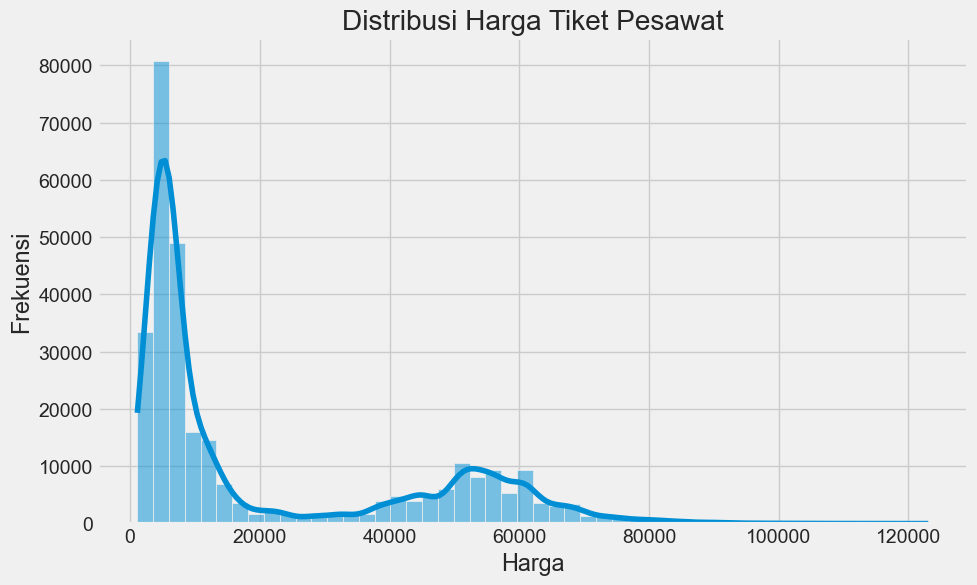

Insight: Distribusi harga sangat miring (skewed), dengan dua puncak yang kemungkinan besar mewakili kelas Ekonomi dan Bisnis.


In [18]:
print("\n--- 2.1 Distribusi Harga (Target Variable) ---")
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['price'], bins=50, kde=True)
plt.title('Distribusi Harga Tiket Pesawat')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')
plt.show()
print("Insight: Distribusi harga sangat miring (skewed), dengan dua puncak yang kemungkinan besar mewakili kelas Ekonomi dan Bisnis.")

- Terlihat dua puncak (bimodal) → menunjukkan ada dua segmen harga: Ekonomi & Bisnis

- Harga ekonomi dominan di bawah 20.000, bisnis di atas 40.000  
🔁 Langkah selanjutnya: pertimbangkan membuat 2 model terpisah berdasarkan kelas (class)


--- 2.2 Analisis Berdasarkan Fitur ---


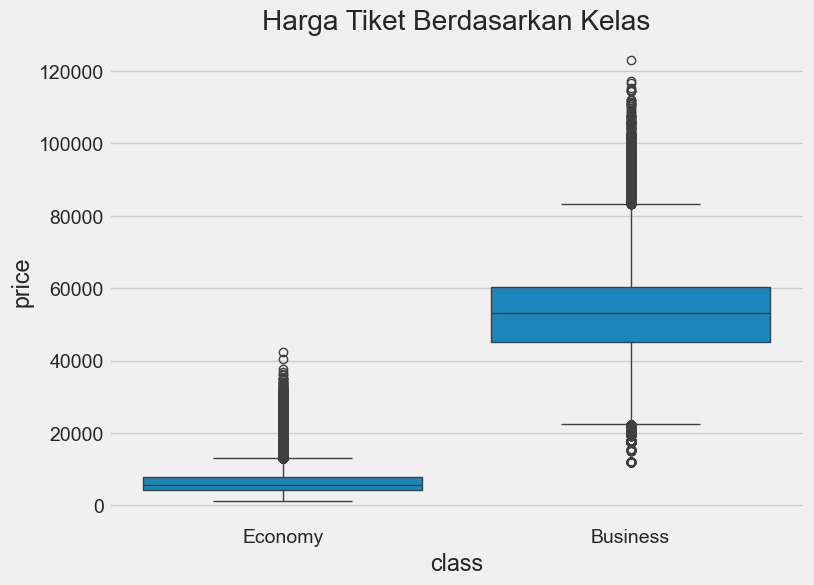

Insight: Harga kelas Bisnis secara signifikan lebih tinggi dan memiliki variasi lebih besar.


In [19]:
print("\n--- 2.2 Analisis Berdasarkan Fitur ---")

# Harga vs. Kelas Penerbangan
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='price', data=df_raw)
plt.title('Harga Tiket Berdasarkan Kelas')
plt.show()
print("Insight: Harga kelas Bisnis secara signifikan lebih tinggi dan memiliki variasi lebih besar.")


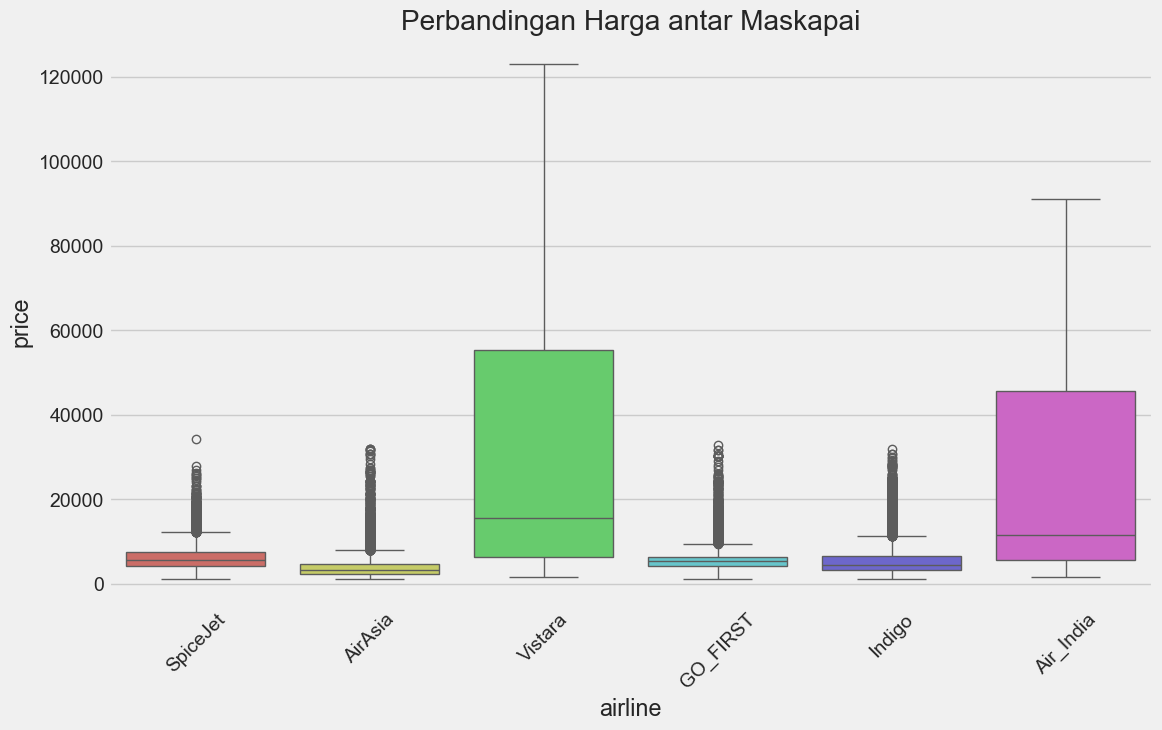

Insight: Vistara dan Air India memiliki rentang harga tertinggi, kemungkinan karena melayani kelas Bisnis.


In [20]:
# Harga vs. Maskapai
plt.figure(figsize=(12, 7))
sns.boxplot(x='airline', y='price', data=df_raw, palette='hls')
plt.title('Perbandingan Harga antar Maskapai')
plt.xticks(rotation=45)
plt.show()
print("Insight: Vistara dan Air India memiliki rentang harga tertinggi, kemungkinan karena melayani kelas Bisnis.")



- Maskapai full-service (Vistara, Air India) memiliki harga jauh lebih tinggi

- Maskapai LCC (Indigo, AirAsia, GO_FIRST, SpiceJet) lebih murah & stabil  
🔁 Langkah selanjutnya: maskapai dapat dimasukkan sebagai fitur penting untuk segmentasi/prediksi

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64


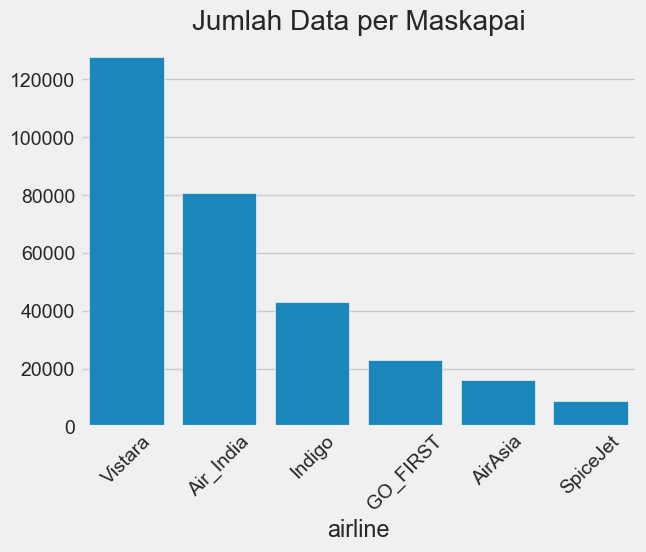

In [21]:
# Jumlah data tiap maskapai
maskapai_count = df_raw['airline'].value_counts()
print(maskapai_count)
sns.barplot(x=maskapai_count.index, y=maskapai_count.values)
plt.xticks(rotation=45)
plt.title('Jumlah Data per Maskapai')
plt.show()

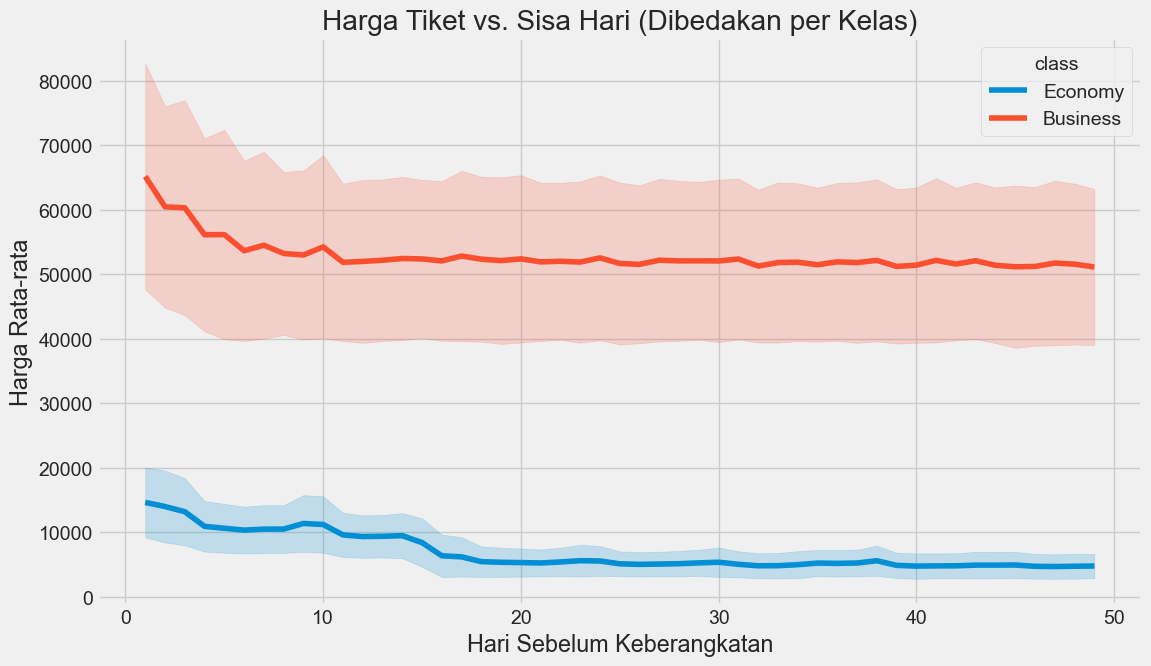

Insight: Harga untuk kedua kelas meningkat tajam saat mendekati tanggal keberangkatan, terutama dalam 10 hari terakhir.


In [22]:
# Harga vs. Sisa Hari Sebelum Keberangkatan
plt.figure(figsize=(12, 7))
sns.lineplot(x='days_left', y='price', data=df_raw, hue='class', errorbar='sd')
plt.title('Harga Tiket vs. Sisa Hari (Dibedakan per Kelas)')
plt.xlabel('Hari Sebelum Keberangkatan')
plt.ylabel('Harga Rata-rata')
plt.grid(True)
plt.show()
print("Insight: Harga untuk kedua kelas meningkat tajam saat mendekati tanggal keberangkatan, terutama dalam 10 hari terakhir.")

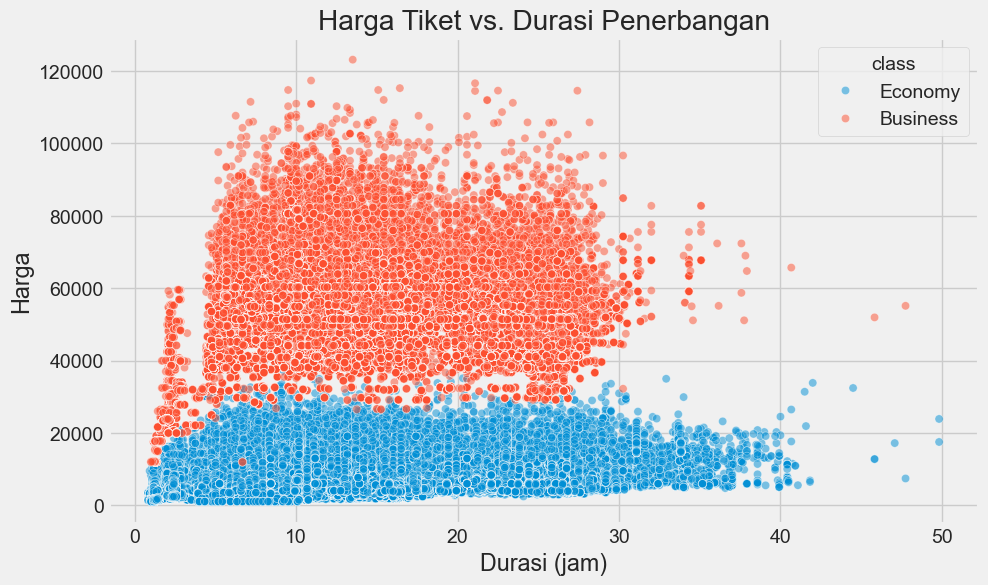

Insight: Durasi yang lebih lama tidak selalu berarti harga lebih tinggi, tetapi penerbangan kelas Bisnis yang mahal seringkali memiliki durasi yang lebih lama (kemungkinan karena rute internasional atau transit).


In [23]:
# Harga vs. Durasi
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='price', data=df_raw, hue='class', alpha=0.5)
plt.title('Harga Tiket vs. Durasi Penerbangan')
plt.xlabel('Durasi (jam)')
plt.ylabel('Harga')
plt.show()
print("Insight: Durasi yang lebih lama tidak selalu berarti harga lebih tinggi, tetapi penerbangan kelas Bisnis yang mahal seringkali memiliki durasi yang lebih lama (kemungkinan karena rute internasional atau transit).")


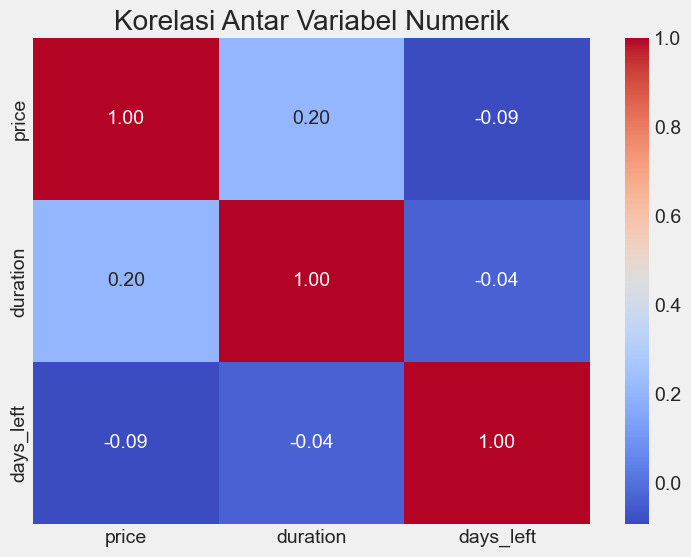

In [24]:
# Korelasi antar fitur numerik
plt.figure(figsize=(8, 6))
sns.heatmap(df_raw[['price', 'duration', 'days_left']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Variabel Numerik')
plt.show()

---
# 3. Data Preprocessing & Feature Engineering

In [25]:
# Kita akan membuat salinan data untuk dimodifikasi
df_processed = df_raw.copy()

### Pembersihan dan Transformasi Awal

In [26]:
# Menghapus kolom yang tidak relevan
df_processed.drop(columns=['Unnamed: 0', 'flight'], inplace=True)

Model memerlukan input numerik, jadi kita ubah kolom teks menjadi angka.  
- Membuat dictionary untuk memetakan nilai 'stops' dari teks ke angka
- Membuat dictionary untuk memetakan nilai 'class' dari teks ke angka (0 untuk Ekonomi, 1 untuk Bisnis)

In [27]:
# Mengubah 'stops' dan 'class' menjadi numerik
stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
class_mapping = {'Economy': 0, 'Business': 1}

In [28]:
# Mengaplikasikan pemetaan tersebut ke kolom yang sesuai
df_processed['stops'] = df_processed['stops'].map(stops_mapping)
df_processed['class'] = df_processed['class'].map(class_mapping)

### Feature Engineering

Ini adalah langkah kreatif untuk membuat fitur baru yang lebih informatif dari data yang ada.

In [29]:
# Menghitung tanggal keberangkatan berdasarkan 'days_left'.
# Kita gunakan asumsi tanggal scraping yang sama untuk konsistensi.
scrape_date = pd.to_datetime('2025-07-25')
df_processed['departure_date'] = scrape_date + pd.to_timedelta(df_processed['days_left'], unit='d')


Membuat fitur-fitur musim sementara

> is_weekend

In [30]:
# dayofweek mengembalikan angka 0 untuk Senin hingga 6 untuk Minggu.
df_processed['is_weekend'] = df_processed['departure_date'].dt.dayofweek.apply(lambda x: 1 if x >= 4 else 0)

> peak_season

In [31]:
# Contoh: Liburan musim panas (misal, pertengahan Agustus) dan akhir tahun (Desember).
summer_peak_start = pd.to_datetime('2025-08-10')
summer_peak_end = pd.to_datetime('2025-08-25')
winter_peak_start = pd.to_datetime('2025-12-20')
winter_peak_end = pd.to_datetime('2025-12-31')
df_processed['peak_season'] = df_processed['departure_date'].apply(
    lambda x: 1 if (summer_peak_start <= x <= summer_peak_end) or (winter_peak_start <= x <= winter_peak_end) else 0
)

> is_national_holiday

In [32]:
holiday_dates_str = ['2025-08-15', '2025-10-02', '2025-10-20', '2025-12-25']
holiday_dates = [pd.to_datetime(date) for date in holiday_dates_str]
holiday_window = set()
for date in holiday_dates:
    for i in range(-2, 2):
        holiday_window.add(date + pd.Timedelta(days=i))
df_processed['is_national_holiday'] = df_processed['departure_date'].apply(
    lambda x: 1 if x in holiday_window else 0
)

> 'seasonality_score'

In [33]:
# Menggabungkan 3 fitur musim menjadi satu skor bertingkat
def get_seasonality_score(row):
    if row['is_national_holiday'] == 1:
        return 3 # Prioritas tertinggi: Libur Nasional
    elif row['is_weekend'] == 1:
        return 2 # Prioritas kedua: Akhir Pekan
    elif row['peak_season'] == 1:
        return 1 # Prioritas terendah: Musim Ramai
    else:
        return 0 # Hari Biasa
df_processed['seasonality_score'] = df_processed.apply(get_seasonality_score, axis=1)

# FITUR LAINNYA

Fitur lainnya:  


Membuat fitur `route` dengan menggabungkan kota asal dan tujuan.

In [34]:
df_processed['route'] = df_processed['source_city'] + '_' + df_processed['destination_city']

Membuat fitur 'booking_window' untuk mengelompokkan sisa hari.

In [35]:
def get_booking_window(days):
    if days <= 2: return 'Last_Minute'
    elif days <= 7: return 'One_Week_Out'
    elif days <= 15: return 'Two_Weeks_Out'
    elif days <= 30: return 'One_Month_Out'
    else: return 'More_Than_Month'
# Mengaplikasikan fungsi tersebut untuk membuat kolom baru
df_processed['booking_window'] = df_processed['days_left'].apply(get_booking_window)

---
# 4. EDA Lanjutan

Sebelum membuat model, kita harus "berkenalan" dengan data kita. Tahap EDA ini bertujuan untuk memvalidasi fitur-fitur baru kita dan mencari wawasan bisnis yang tersembunyi melalui visualisasi.

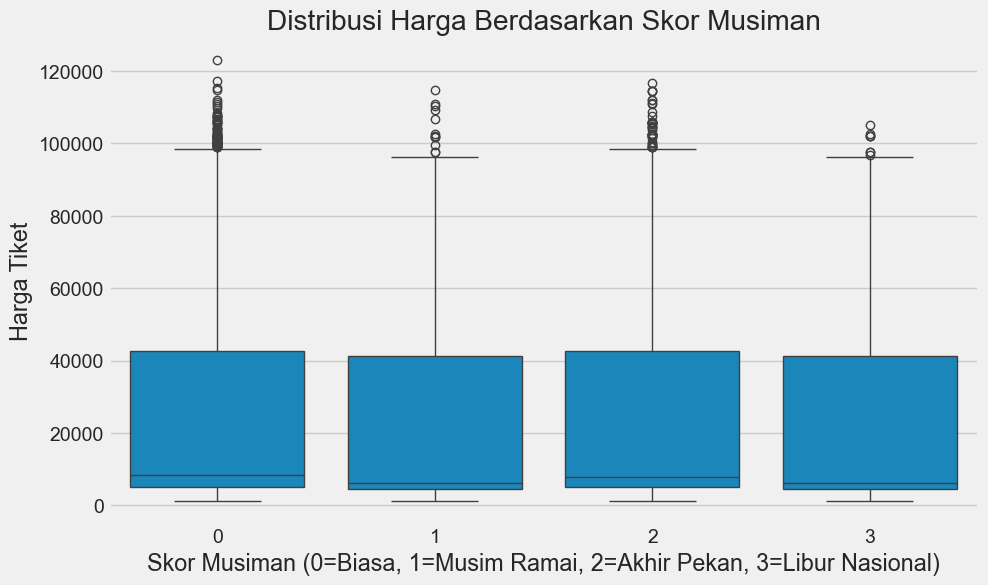

In [36]:
# --- Analisis 1: Fitur Skor Musiman ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='seasonality_score', y='price', data=df_processed)
plt.title('Distribusi Harga Berdasarkan Skor Musiman')
plt.xlabel('Skor Musiman (0=Biasa, 1=Musim Ramai, 2=Akhir Pekan, 3=Libur Nasional)')
plt.ylabel('Harga Tiket')
plt.show()

In [37]:
# --- Analisis 2: Rute Termahal dan Termurah ---
route_prices = df_processed.groupby('route')['price'].mean().sort_values(ascending=False)
print("\nTop 5 Rute Termahal (Rata-rata):")
print(route_prices.head(5))
print("\nTop 5 Rute Termurah (Rata-rata):")
print(route_prices.tail(5))


Top 5 Rute Termahal (Rata-rata):
route
Chennai_Bangalore    25081.850454
Kolkata_Chennai      23660.361040
Bangalore_Kolkata    23500.061229
Bangalore_Chennai    23321.850078
Mumbai_Bangalore     23147.873807
Name: price, dtype: float64

Top 5 Rute Termurah (Rata-rata):
route
Mumbai_Delhi       18725.320008
Delhi_Bangalore    17880.216315
Bangalore_Delhi    17723.313972
Delhi_Hyderabad    17347.288379
Hyderabad_Delhi    17243.945685
Name: price, dtype: float64


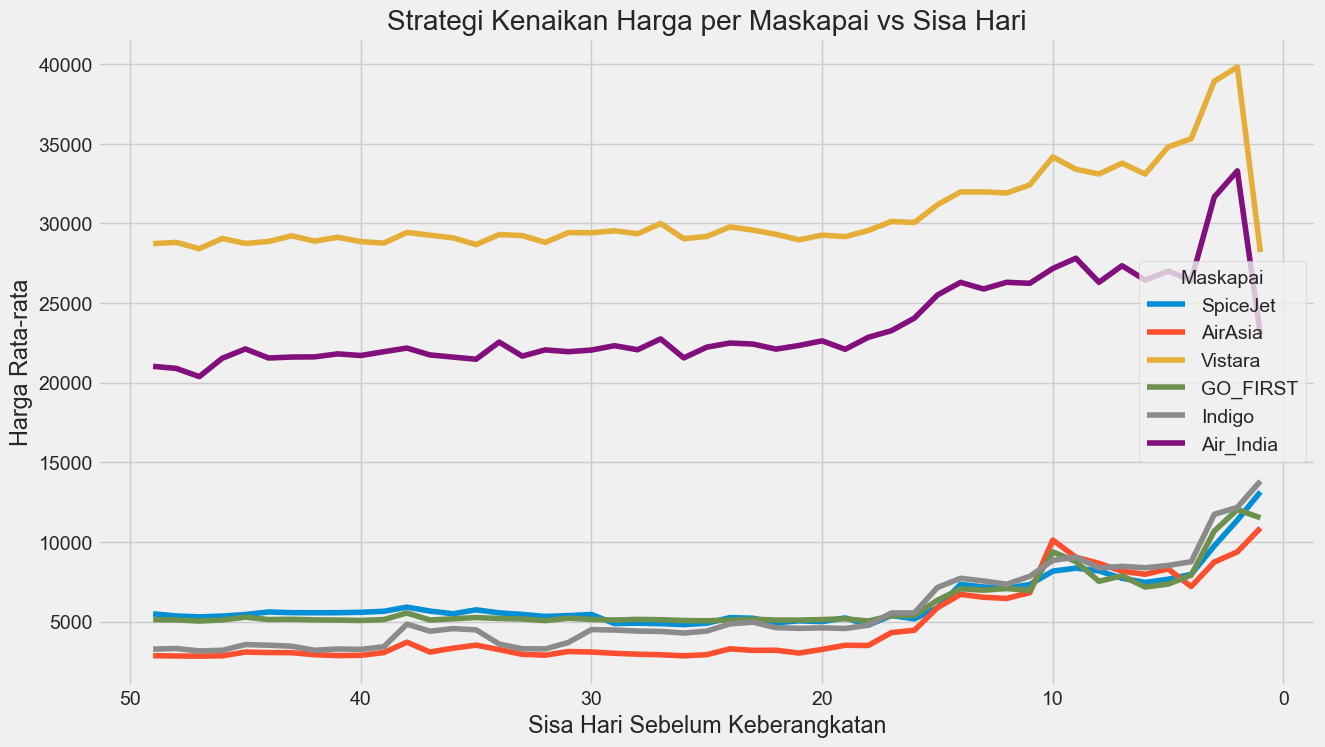

In [38]:
# --- Analisis 3: Strategi Harga Maskapai ---
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_processed, x='days_left', y='price', hue='airline', errorbar=None)
plt.title('Strategi Kenaikan Harga per Maskapai vs Sisa Hari')
plt.xlabel('Sisa Hari Sebelum Keberangkatan')
plt.ylabel('Harga Rata-rata')
plt.legend(title='Maskapai')
plt.gca().invert_xaxis() # Membalik sumbu x agar lebih intuitif
plt.show()

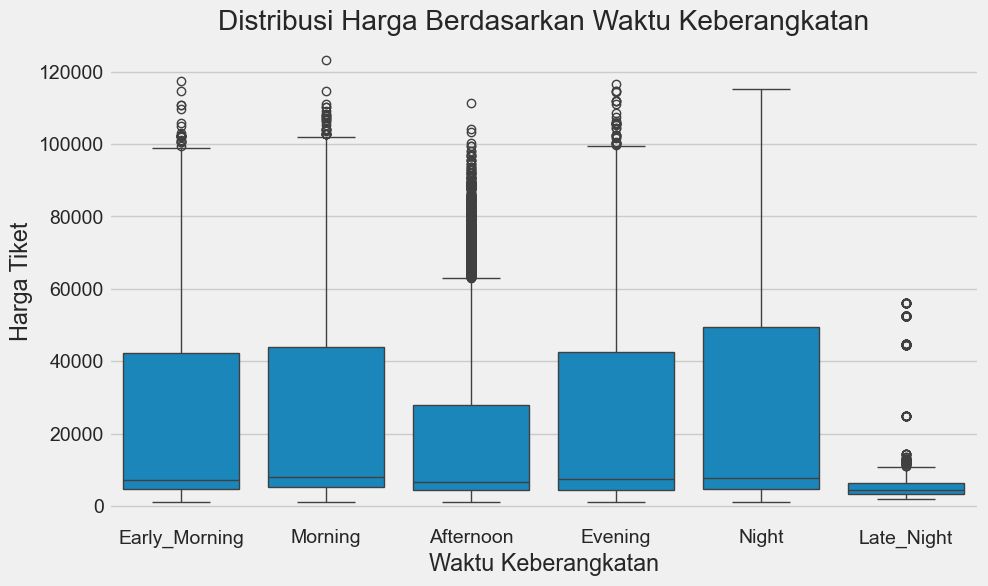

In [39]:
# --- Analisis 4: Pengaruh Waktu Keberangkatan ---
plt.figure(figsize=(10, 6))
departure_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']
sns.boxplot(x='departure_time', y='price', data=df_processed, order=departure_order)
plt.title('Distribusi Harga Berdasarkan Waktu Keberangkatan')
plt.xlabel('Waktu Keberangkatan')
plt.ylabel('Harga Tiket')
plt.show()

In [40]:
# --- Analisis 2: Rute Termahal dan Termurah ---
route_prices = df_processed.groupby('route')['price'].mean().sort_values(ascending=False)
print("\nTop 5 Rute Termahal (Rata-rata):")
print(route_prices.head(5))
print("\nTop 5 Rute Termurah (Rata-rata):")
print(route_prices.tail(5))


Top 5 Rute Termahal (Rata-rata):
route
Chennai_Bangalore    25081.850454
Kolkata_Chennai      23660.361040
Bangalore_Kolkata    23500.061229
Bangalore_Chennai    23321.850078
Mumbai_Bangalore     23147.873807
Name: price, dtype: float64

Top 5 Rute Termurah (Rata-rata):
route
Mumbai_Delhi       18725.320008
Delhi_Bangalore    17880.216315
Bangalore_Delhi    17723.313972
Delhi_Hyderabad    17347.288379
Hyderabad_Delhi    17243.945685
Name: price, dtype: float64


---
# 5. Pemodelan Data

**Tujuan:**   
  
  - Membangun model machine learning untuk memprediksi harga tiket pesawat (price) berdasarkan fitur yang tersedia
  - lalu mengevaluasi performanya secara kuantitatif dan bisnis.  

Kita akan menyiapkan data final, melatih beberapa model untuk perbandingan, lalu mengambil model terbaik untuk di"sempurnakan" melalui proses Hyperparameter Tuning dengan Cross-Validation.

### **Finalisasi Data untuk Model**

In [41]:
# Menghapus kolom-kolom asli yang informasinya sudah kita tangkap dalam fitur-fitur baru
df_final = df_processed.drop(columns=['source_city', 'destination_city', 'departure_date', 'is_weekend', 'peak_season', 'is_national_holiday'])

In [42]:
# Mengidentifikasi kolom yang masih berupa teks (kategorikal)
categorical_cols = df_final.select_dtypes(include=['object']).columns

In [43]:
# drop_first=True untuk menghindari redundansi informasi (multicollinearity).
# Melakukan One-Hot Encoding pada kolom kategorikal yang tersisa
df_final = pd.get_dummies(df_final, columns=df_final.select_dtypes(include=['object']).columns, drop_first=True)

In [44]:
print("Persiapan data dan feature engineering selesai.")
print(f"Dimensi data akhir siap untuk modeling: {df_final.shape}")
print("Kolom akhir untuk modeling:")
print(df_final.columns.tolist())

Persiapan data dan feature engineering selesai.
Dimensi data akhir siap untuk modeling: (300153, 54)
Kolom akhir untuk modeling:
['stops', 'class', 'duration', 'days_left', 'price', 'seasonality_score', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'departure_time_Early_Morning', 'departure_time_Evening', 'departure_time_Late_Night', 'departure_time_Morning', 'departure_time_Night', 'arrival_time_Early_Morning', 'arrival_time_Evening', 'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night', 'route_Bangalore_Delhi', 'route_Bangalore_Hyderabad', 'route_Bangalore_Kolkata', 'route_Bangalore_Mumbai', 'route_Chennai_Bangalore', 'route_Chennai_Delhi', 'route_Chennai_Hyderabad', 'route_Chennai_Kolkata', 'route_Chennai_Mumbai', 'route_Delhi_Bangalore', 'route_Delhi_Chennai', 'route_Delhi_Hyderabad', 'route_Delhi_Kolkata', 'route_Delhi_Mumbai', 'route_Hyderabad_Bangalore', 'route_Hyderabad_Chennai', 'route_Hyderabad_Delhi', 'ro

In [45]:
# Tampilkan 5 baris pertama data
print("\nContoh data setelah preprocessing:")
display(df_final.head())

# Tampilkan semua kolom dengan tipe data
print("\nDaftar kolom dan tipe datanya:")
for col in df_final.columns:
    print(f"- {col}: {df_final[col].dtype}")

# Cek apakah masih ada missing values
missing = df_final.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("\n⚠️ Missing values ditemukan:")
    print(missing)
else:
    print("\nTidak ada missing values!")


Contoh data setelah preprocessing:


,stops,class,duration,days_left,price,seasonality_score,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,route_Bangalore_Delhi,route_Bangalore_Hyderabad,route_Bangalore_Kolkata,route_Bangalore_Mumbai,route_Chennai_Bangalore,route_Chennai_Delhi,route_Chennai_Hyderabad,route_Chennai_Kolkata,route_Chennai_Mumbai,route_Delhi_Bangalore,route_Delhi_Chennai,route_Delhi_Hyderabad,route_Delhi_Kolkata,route_Delhi_Mumbai,route_Hyderabad_Bangalore,route_Hyderabad_Chennai,route_Hyderabad_Delhi,route_Hyderabad_Kolkata,route_Hyderabad_Mumbai,route_Kolkata_Bangalore,route_Kolkata_Chennai,route_Kolkata_Delhi,route_Kolkata_Hyderabad,route_Kolkata_Mumbai,route_Mumbai_Bangalore,route_Mumbai_Chennai,route_Mumbai_Delhi,route_Mumbai_Hyderabad,route_Mumbai_Kolkata,booking_window_More_Than_Month,booking_window_One_Month_Out,booking_window_One_Week_Out,booking_window_Two_Weeks_Out
0,0,0,2.17,1,5953,2,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0,2.33,1,5953,2,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0,2.17,1,5956,2,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,0,2.25,1,5955,2,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,0,2.33,1,5955,2,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False



Daftar kolom dan tipe datanya:
- stops: int64
- class: int64
- duration: float64
- days_left: int64
- price: int64
- seasonality_score: int64
- airline_Air_India: bool
- airline_GO_FIRST: bool
- airline_Indigo: bool
- airline_SpiceJet: bool
- airline_Vistara: bool
- departure_time_Early_Morning: bool
- departure_time_Evening: bool
- departure_time_Late_Night: bool
- departure_time_Morning: bool
- departure_time_Night: bool
- arrival_time_Early_Morning: bool
- arrival_time_Evening: bool
- arrival_time_Late_Night: bool
- arrival_time_Morning: bool
- arrival_time_Night: bool
- route_Bangalore_Delhi: bool
- route_Bangalore_Hyderabad: bool
- route_Bangalore_Kolkata: bool
- route_Bangalore_Mumbai: bool
- route_Chennai_Bangalore: bool
- route_Chennai_Delhi: bool
- route_Chennai_Hyderabad: bool
- route_Chennai_Kolkata: bool
- route_Chennai_Mumbai: bool
- route_Delhi_Bangalore: bool
- route_Delhi_Chennai: bool
- route_Delhi_Hyderabad: bool
- route_Delhi_Kolkata: bool
- route_Delhi_Mumbai: bool

In [46]:
df_final.isnull().sum()

stops                             0
class                             0
duration                          0
days_left                         0
price                             0
seasonality_score                 0
airline_Air_India                 0
airline_GO_FIRST                  0
airline_Indigo                    0
airline_SpiceJet                  0
airline_Vistara                   0
departure_time_Early_Morning      0
departure_time_Evening            0
departure_time_Late_Night         0
departure_time_Morning            0
departure_time_Night              0
arrival_time_Early_Morning        0
arrival_time_Evening              0
arrival_time_Late_Night           0
arrival_time_Morning              0
arrival_time_Night                0
route_Bangalore_Delhi             0
route_Bangalore_Hyderabad         0
route_Bangalore_Kolkata           0
route_Bangalore_Mumbai            0
route_Chennai_Bangalore           0
route_Chennai_Delhi               0
route_Chennai_Hyderabad     

### Pemisahan Data

In [47]:
# Memisahkan fitur (semua kolom kecuali 'price') dan target (kolom 'price')
X = df_final.drop(columns='price')
y = df_final['price']

In [48]:
# Membagi data menjadi 80% untuk training (melatih model) dan 20% untuk testing (menguji model)
# random_state=42 memastikan pembagian data selalu sama setiap kali kode dijalankan, untuk hasil yang konsisten.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Shapes dari pemisahan
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (240122, 53)
Testing features shape: (60031, 53)
Training target shape: (240122,)
Testing target shape: (60031,)


In [50]:
def check_nan(df_final, name="Data"):
    total_nan = df_final.isna().sum().sum()
    nan_per_col = df_final.isna().sum()
    nan_cols = nan_per_col[nan_per_col > 0]
    percent_nan = (total_nan / (df_final.shape[0] * df_final.shape[1])) * 100
    print(f"\n{name}:")
    print(f"Total missing values: {total_nan}")
    print(f"Percentage missing: {percent_nan:.4f}%")
    if not nan_cols.empty:
        print("Columns with missing values:")
        print(nan_cols)
    else:
        print("Tidak ada missing values di kolom manapun.")

# Cek missing value di setiap feature set
check_nan(X_train, "Feature Train")
check_nan(X_test, "Feature Test")



Feature Train:
Total missing values: 0
Percentage missing: 0.0000%
Tidak ada missing values di kolom manapun.

Feature Test:
Total missing values: 0
Percentage missing: 0.0000%
Tidak ada missing values di kolom manapun.


### Pelatihan Model Awal  
Memulai Pelatihan Model Awal untuk Perbandingan

**Model 1: Linear Regression (Model paling sederhana sebagai pembanding)**

In [51]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Model 2: Random Forest

In [52]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Model 3: XGBoost

In [53]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

### Evaluasi Model Awal

In [54]:
# Daftar model yang sudah dilatih
models_trained = {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

In [55]:
# Siapkan list untuk menampung hasil
results_list = []

# Loop melalui setiap model yang sudah dilatih
for name, model in models_trained.items():
    # Evaluasi pada Data Training
    y_pred_train = model.predict(X_train)
    # Evaluasi pada Data Testing
    y_pred_test = model.predict(X_test)
    # Simpan hasil
    results_list.append({
        "Model": name,
        "R² Training": r2_score(y_train, y_pred_train), "R² Testing": r2_score(y_test, y_pred_test),
        "RMSE Training": np.sqrt(mean_squared_error(y_train, y_pred_train)), "RMSE Testing": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE Training": mean_absolute_error(y_train, y_pred_train), "MAE Testing": mean_absolute_error(y_test, y_pred_test)
    })

In [56]:
results_df = pd.DataFrame(results_list)

In [57]:
# --- Tabel untuk Performa TRAINING ---
# Tabel ini digunakan untuk membandingkan dengan hasil testing dan mengecek overfitting.
print("\n\n--- Train Performance ---")
results_train = results_df[['Model', 'R² Training', 'RMSE Training', 'MAE Training']]
results_train.sort_values(by="R² Training", ascending=False)
display(results_train)



--- Train Performance ---


,Model,R² Training,RMSE Training,MAE Training
0,Linear Regression,0.913544,6673.435154,4401.428733
1,Random Forest,0.997473,1140.829350,433.273987
2,XGBoost,0.976612,3470.961759,1960.628522


In [58]:
# --- Tabel untuk Performa TESTING ---
# Ini adalah tabel yang paling penting untuk melihat performa model pada data baru.
print("\n--- Test Performance ---")
results_test = results_df[['Model', 'R² Testing', 'RMSE Testing', 'MAE Testing']]
results_test.sort_values(by="R² Testing", ascending=False)
display(results_test)


--- Test Performance ---


,Model,R² Testing,RMSE Testing,MAE Testing
0,Linear Regression,0.913322,6684.382079,4375.032471
1,Random Forest,0.984743,2804.367865,1113.487880
2,XGBoost,0.974752,3607.614156,2021.777041


Dari hasil awal, `Random Forest` menunjukkan performa terbaik, sehingga kita akan fokus men-tuning model ini.

---
# 6. Pemodelan Data Lanjutan

### Hyperparameter Tuning Pada Model Terbaik

In [59]:
# Tentukan hyperparameter yang ingin di-tuning untuk Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],         # Jumlah pohon
    'max_depth': [10, 20, None],        # Kedalaman maksimum, None berarti tidak ada batas
    'min_samples_split': [2, 5],        # Jumlah sampel minimum untuk membelah node
    'min_samples_leaf': [1, 2]          # Jumlah sampel minimum di daun
}

In [60]:
# Buat instance GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=3, # 3-fold cross-validation
    scoring='neg_mean_squared_error', # Kita optimalkan MSE (akar kuadratnya adalah RMSE)
    verbose=1
)

In [61]:
# Jalankan proses tuning (bisa memakan waktu)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
# Ambil model terbaik hasil tuning
best_rf_model = grid_search_rf.best_estimator_

print("\n--- Hasil Hyperparameter Tuning ---")
print(f"Kombinasi hyperparameter terbaik untuk Random Forest: {grid_search_rf.best_params_}")


--- Hasil Hyperparameter Tuning ---
Kombinasi hyperparameter terbaik untuk Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


### Evaluasi Final

Evaluasi Model Final (Random Forest Hasil Tuning) pada Data Test

In [63]:
# Gunakan model terbaik untuk prediksi
y_pred_final = best_rf_model.predict(X_test)

In [64]:
# Hitung metrik performa final
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print(f"MAE  (Tuned): {final_mae:,.2f}")
print(f"RMSE (Tuned): {final_rmse:,.2f}")
print(f"R²   (Tuned): {final_r2:.4f}")

MAE  (Tuned): 1,115.39
RMSE (Tuned): 2,720.92
R²   (Tuned): 0.9856


In [65]:
# Membuat prediksi pada data training
y_pred_train_final = best_rf_model.predict(X_train)

# Menghitung SEMUA metrik untuk data training (INI BAGIAN YANG DIPERBAIKI)
mae_train_final = mean_absolute_error(y_train, y_pred_train_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
r2_train_final = r2_score(y_train, y_pred_train_final)

In [66]:
# --- Membuat Tabel Ringkasan Final ---
# Sekarang semua variabel sudah terdefinisi
summary_data = {
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Training Set': [r2_train_final, rmse_train_final, mae_train_final],
    'Testing Set': [final_r2, final_rmse, final_mae]
}

summary_df = pd.DataFrame(summary_data).set_index('Metric')

print("\n--- Tabel Ringkasan Performa Model Final ---")
display(summary_df)


--- Tabel Ringkasan Performa Model Final ---


,Training Set,Testing Set
Metric,,
R²,0.995268,0.985638
RMSE,1561.198380,2720.915222
MAE,627.909745,1115.387498


### Analisis dan Visualisasi Feature Importance
Top Feature Importance Menurut Model Final

In [67]:
# Definisikan fungsi untuk membuat plot
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:] # Ambil 15 fitur teratas
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Tingkat Kepentingan Relatif')
    plt.tight_layout()
    plt.show()

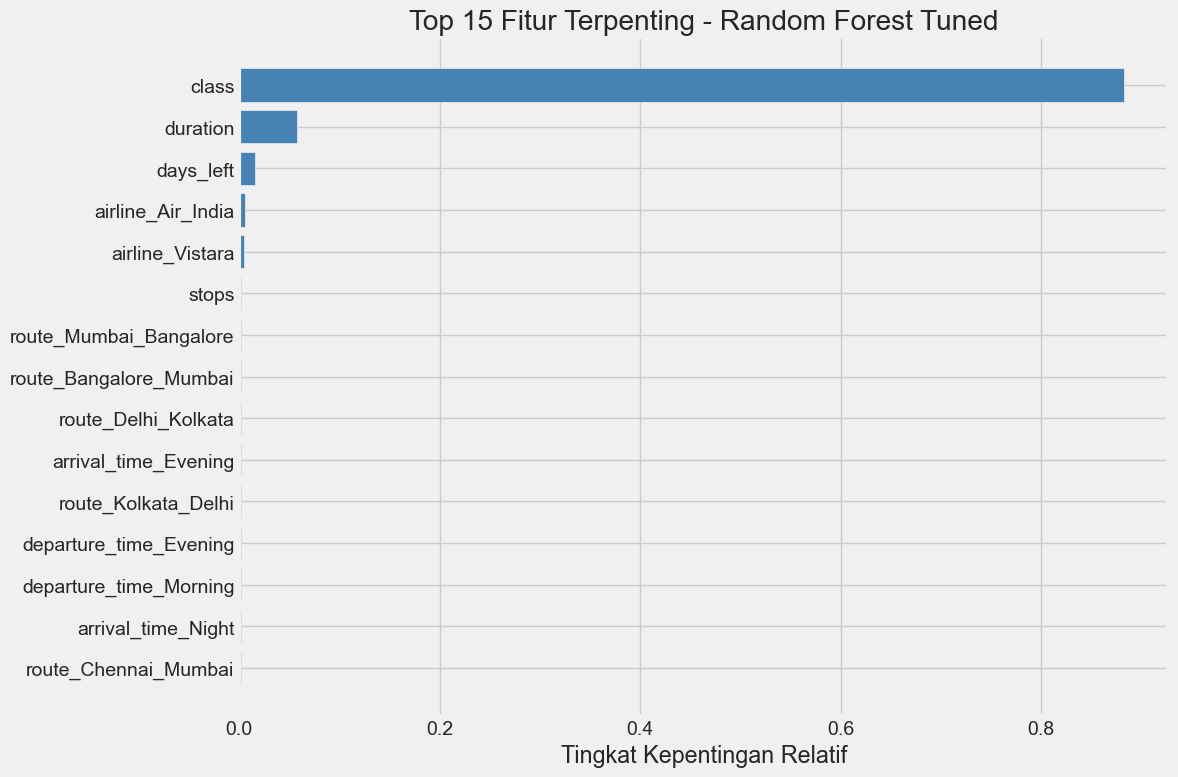

In [68]:
# Panggil fungsi untuk membuat dan menampilkan plot
plot_feature_importance(best_rf_model, X_train.columns, "Top 15 Fitur Terpenting - Random Forest Tuned")


### Visualisasi Hasil Prediksi

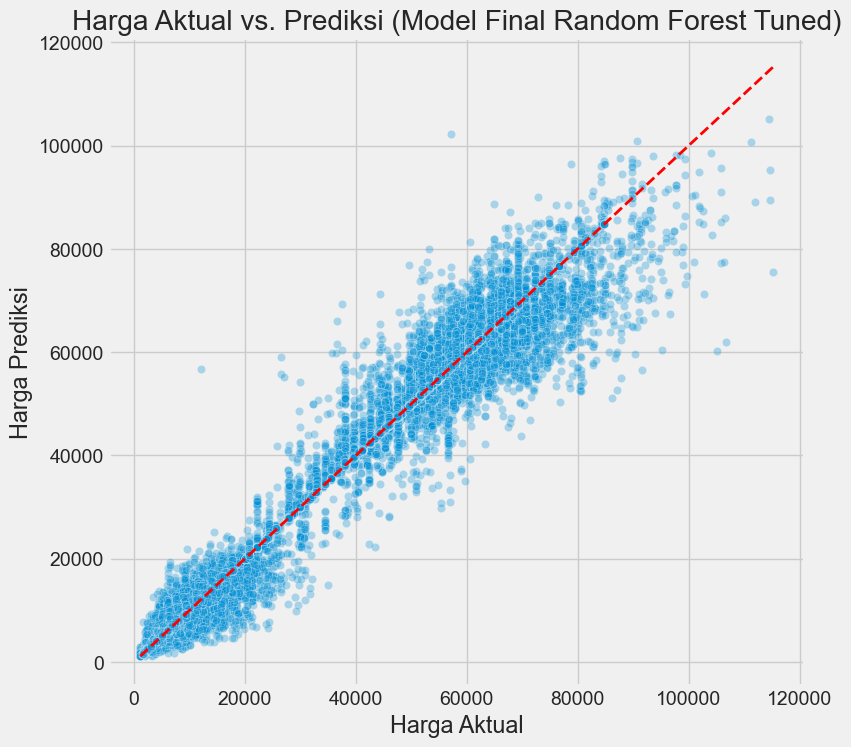

In [69]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Harga Aktual vs. Prediksi (Model Final Random Forest Tuned)")
plt.xlabel("Harga Aktual")
plt.ylabel("Harga Prediksi")
plt.show()


---
# 7. Cek Overfitting

In [70]:
print("\n--- Mengecek Potensi Overfitting ---")
y_pred_train = best_rf_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Perbandingan R²: Training = {r2_train:.4f} vs. Testing = {final_r2:.4f}")
if r2_train > final_r2 and (r2_train - final_r2) > 0.05:
    print("Indikasi Overfitting.")
else:
    print("Model Baik (Good Fit).")


--- Mengecek Potensi Overfitting ---
Perbandingan R²: Training = 0.9953 vs. Testing = 0.9856
Model Baik (Good Fit).


---
# 8. Deployment

In [71]:
# Membuat model "lite" yang lebih cerdas menggunakan parameter terbaik dari tuning
rf_model_deploy = RandomForestRegressor(
    n_estimators=50,  # <-- Kita kurangi ini untuk ukuran file yang kecil
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    # min_samples_leaf juga bisa ditambahkan jika ada di best_params
    random_state=42,
    n_jobs=-1
)

In [72]:
# Latih model "lite" ini
rf_model_deploy.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [77]:
# Simpan model dan kolom untuk digunakan di aplikasi Streamlit
import joblib
joblib.dump(rf_model_deploy, 'flight_price_model.pkl')
joblib.dump(X_train.columns, 'flight_price_columns.pkl')

print("✅ Model 'flight_price_model.pkl' dan 'flight_price_columns.pkl' berhasil disimpan dan siap untuk di-deploy.")
print("\n--- Analisis Selesai ---")


✅ Model 'flight_price_model.pkl' dan 'flight_price_columns.pkl' berhasil disimpan dan siap untuk di-deploy.

--- Analisis Selesai ---


In [78]:
import sklearn
print(sklearn.__version__)


1.5.1
